In [1]:
!pip install wget
!pip install tensorflow_datasets

In [3]:
# Import required libraries and modules
import base64
import json
import os
import platform
import requests
import tarfile
import zipfile
import jmespath
import subprocess
import wget
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds


from IPython.core.display import display, HTML

Matplotlib created a temporary config/cache directory at /tmp/1000650000/matplotlib-ha9l8rxl because the default path (/home/wsuser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir="../data_asset"
)

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [6]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.cast(tf.keras.backend.argmax(x), dtype='int32'), name='classes'))

Epoch 1/6
469/469 [==============================] - 4s 8ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.4724 - val_sparse_categorical_accuracy: 0.8904
Epoch 2/6
469/469 [==============================] - 4s 8ms/step - loss: 0.4873 - sparse_categorical_accuracy: 0.8872 - val_loss: 0.4490 - val_sparse_categorical_accuracy: 0.9023
Epoch 3/6
469/469 [==============================] - 4s 8ms/step - loss: 0.4927 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.6349 - val_sparse_categorical_accuracy: 0.8859
Epoch 4/6
469/469 [==============================] - 4s 8ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.8801 - val_loss: 0.5546 - val_sparse_categorical_accuracy: 0.8816
Epoch 5/6
469/469 [==============================] - 4s 8ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.6295 - val_sparse_categorical_accuracy: 0.8653
Epoch 6/6
469/469 [==============================] - 4s 8ms/step - loss: 0.5939 - sparse_categorical_accu

In [8]:
model.predict(ds_test)

array([2, 0, 4, ..., 8, 0, 5], dtype=int32)

In [9]:
model_name='mnist-dl-model.tar.gz'
tf.saved_model.save(model, model_name)

2022-04-21 13:10:58.930370: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mnist-dl-model.tar.gz/assets


INFO:tensorflow:Assets written to: mnist-dl-model.tar.gz/assets


In [10]:
!ls


'MLOps Workshop.ipynb'	 mnist-dl-model.tar.gz.tar.gz
 mnist-dl-model.tar.gz	 mnist-html-canvas-image-data.json


In [11]:
cpdtoken=os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
    "token": cpdtoken,
    "instance_id" : "openshift",
    "url": os.environ['RUNTIME_ENV_APSX_URL'],
    "version": "4.0"
}

In [12]:
from ibm_watson_machine_learning import APIClient
client = APIClient(wml_credentials)

In [13]:
# List deployment spaces

client.spaces.list(limit=10)

------------------------------------  ----  ------------------------
ID                                    NAME  CREATED
eca14e28-329a-4dee-bd00-15579d43c458  test  2022-04-21T08:27:41.680Z
8c4d0b78-c9b7-42e1-bca2-89fe8be611a9  yest  2022-04-20T13:03:40.914Z
------------------------------------  ----  ------------------------


In [14]:
space_id = 'eca14e28-329a-4dee-bd00-15579d43c458'

# Codice opzionale per creare il deployment space da codice

In [15]:
client.set.default_space(space_id)

'SUCCESS'

In [16]:
sofware_spec_uid = client.software_specifications.get_id_by_name("tensorflow_rt22.1-py3.9")


metadata = {
            client.repository.ModelMetaNames.NAME: 'MNIST Tensorflow Model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.7',
            client.repository.ModelMetaNames.TAGS: ['v1','OCR'],
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

model_details = client.repository.store_model(
    model=model_name,
    meta_props=metadata
)

In [17]:
client.repository.get_details()

{'models': {'resources': [{'entity': {'hybrid_pipeline_software_specs': [],
     'software_spec': {'id': 'fe185c44-9a99-5425-986b-59bd1d2eda46',
      'name': 'tensorflow_2.4-py3.8'},
     'type': 'tensorflow_2.4'},
    'metadata': {'created_at': '2022-04-21T08:28:22.002Z',
     'id': 'e7393538-3cb0-4c6d-ab6a-6801afc8d4d5',
     'modified_at': '2022-04-21T08:28:24.334Z',
     'name': 'MNIST model',
     'owner': '1000330999',
     'resource_key': 'f87f5821-05ab-4331-8685-bc58cf085fed',
     'space_id': 'eca14e28-329a-4dee-bd00-15579d43c458',
     'tags': ['v1']},
    'system': {'warnings': [{'message': 'Software specification tensorflow_2.4-py3.8 specified for the wml_model is deprecated and will be removed in the future. We recommend you use tensorflow_rt22.1-py3.9 instead. For details see Supported Frameworks https://www.ibm.com/docs/en/cloud-paks/cp-data/4.0?topic=specifications-supported-deployment-frameworks'}]}},
   {'entity': {'hybrid_pipeline_software_specs': [],
     'software

In [18]:
# Get published model ID

published_model_uid = client.repository.get_model_id(model_details)
published_model_uid

'51e91c3c-cf1b-4e7a-b97b-44489efde51a'

In [19]:
# Deploy the stored model
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST Tensorflow Deployed Model",
    client.deployments.ConfigurationMetaNames.TAGS: ['v1','OCR'],
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

model_deployment_details = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '51e91c3c-cf1b-4e7a-b97b-44489efde51a' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.....
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='dd7d868e-efe8-418d-9459-7aaa5533dce4'
------------------------------------------------------------------------------------------------




In [20]:
# Get the ID of the model deployment just created

model_deployment_id = client.deployments.get_uid(model_deployment_details)
model_deployment_id

'dd7d868e-efe8-418d-9459-7aaa5533dce4'

In [21]:
# Download the file containing the sample data

sample_canvas_data_filename = 'mnist-html-canvas-image-data.json'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/mnist/' + sample_canvas_data_filename
if not os.path.isfile(sample_canvas_data_filename): wget.download(url)

# Load the sample data from the file into a variable

with open(sample_canvas_data_filename) as data_file:
    sample_cavas_data = json.load(data_file)

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values



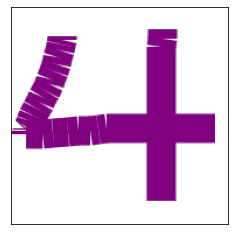

In [22]:
# View the raw contents of the sample data

print("Height (n): " + str(sample_cavas_data["height"]) + " pixels\n")
print("Num image data entries: " + str(len( sample_cavas_data["data"])) + " - (n * n * 4) elements - RGBA values\n")
# print(json.dumps(sample_cavas_data, indent=3)[:75] + "...\n" + json.dumps(sample_cavas_data, indent=3)[-50:])

# See what hand-drawn digit the sample data represents

rgba_arr = np.asarray(sample_cavas_data["data"]).astype('uint8')
n = sample_cavas_data["height"]
plt.figure()
plt.imshow( rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

In [23]:
# Preprocessing data

def getRGBAArr(canvas_data):
    import numpy as np
    dimension = canvas_data["height"]
    rgba_data = canvas_data["data"]
    rgba_arr  = np.asarray(rgba_data).astype('uint8')
    return rgba_arr.reshape(dimension, dimension, 4)

def getNormAlphaList(img):
    import numpy as np
    alpha_arr       = np.array(img.split()[-1])
    norm_alpha_arr  = alpha_arr / 255
    # norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()
    # return norm_alpha_list
    return norm_alpha_arr


from PIL import Image
canvas_data   = sample_cavas_data       # Read the payload received by the function
rgba_arr      = getRGBAArr(canvas_data)               # Create an array object with the required shape
img           = Image.fromarray(rgba_arr, 'RGBA')     # Create an image object that can be resized
sm_img        = img.resize((28, 28), Image.LANCZOS) # Resize the image to 28 x 28 pixels
alpha_list    = getNormAlphaList(sm_img)              # Create a 1 x 784 array of values between 0 and 1
alpha_list    = alpha_list.reshape((1,28,28))
model_payload = {"input_data": [{"values" : alpha_list}]} 

In [24]:
# Predict via API

predictions = client.deployments.score(model_deployment_id, model_payload)
print(json.dumps(predictions))

{"predictions": [{"id": "classes", "values": [2]}]}


In [25]:
# Predict via HTTP request

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + cpdtoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = model_payload

response_scoring = requests.post('https://cpd-cpd-instance.itzroks-666000zj44-v4b1yc-4b4a324f027aea19c5cbc0c3275c4656-0000.eu-de.containers.appdomain.cloud/ml/v4/deployments/04efa377-8f19-40b6-b3da-f940a7cde716/predictions?version=2022-04-21', json=payload_scoring, headers=header, verify=False)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'predictions': [{'id': 'y_pred', 'values': [4.0]}]}
